# Logistic Regression
Implementing logistic regression for sentiment analysis on tweets. Given a tweet, decide if it has a positive sentiment or a negative one. Specifically : 

* Extracting features for logistic regression given some text
* Implement logistic regression from scratch
* Apply logistic regression on a natural language processing task
* Test using logistic regression
* Perform error analysis

We will be using a data set of tweets. Hopefully we will get more than 99% accuracy. 

## Import libraries  and data

In [11]:
import nltk
import matplotlib.pyplot as plt
# nltk.download('twitter_samples')
# nltk.download('stopwords')

In [2]:
import numpy as np
import pandas as pd
from nltk.corpus import twitter_samples 

### Prepare the data
* The `twitter_samples` contains subsets of 5,000 positive tweets, 5,000 negative tweets, and the full set of 10,000 tweets.  
    * If used all three datasets, we would introduce duplicates of the positive tweets and negative tweets.  
    * Selecting just the five thousand positive tweets and five thousand negative tweets.

In [3]:
# select the set of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

* Train test split: 20% will be in the test set, and 80% in the training set.


In [4]:
# split the data into two pieces, one for training and one for testing (validation set) 
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg 
test_x = test_pos + test_neg

* Create the numpy array of positive labels and negative labels.

In [5]:
# combining positive and negative labels
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

In [96]:
# Shape of train and test sets
print("train_y.shape = " + str(train_y.shape))
print("test_y.shape = " + str(test_y.shape))

train_y.shape = (8000, 1)
test_y.shape = (2000, 1)


In [44]:
import re
import string
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer


def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean


def build_freqs(tweets, ys):
    """Build frequencies.
    Input:
        tweets: a list of tweets
        ys: an m x 1 array with the sentiment label of each tweet
            (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its
        frequency
    """
    yslist = np.squeeze(ys).tolist()

    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs


### Process tweet
The given function `process_tweet()` tokenizes the tweet into individual words, removes stop words and applies stemming.

In [34]:
# test the function below
print('This is an example of a positive tweet: \n', train_x[0])
print('\nThis is an example of the processed version of the tweet: \n', process_tweet(train_x[0]))

This is an example of a positive tweet: 
 #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)

This is an example of the processed version of the tweet: 
 ['followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']


## Extracting the features

* Given a list of tweets, extract the features and store them in a matrix. You will extract two features.
    * The first feature is the number of positive words in a tweet.
    * The second feature is the number of negative words in a tweet. 
* Training logistic regression classifier on these features.
* Test the classifier on a validation set. 

In [132]:
def extract_features(tweet, freqs):
    pos_sum = 0
    neg_sum = 0
    for word in process_tweet(tweet):
        neg_sum += freqs.get((word, 0), 0)
        pos_sum += freqs.get((word, 1), 0)

    res = {"bias": 1, "positive": pos_sum, "negative": neg_sum}
    
    return res

In [133]:
freqs = build_freqs(train_x, train_y)

In [134]:
# test on training data
tmp1 = extract_features(train_x[0], freqs)
tmp1

{'bias': 1, 'positive': 3020, 'negative': 61}

In [135]:
# check for when the words are not in the freqs dictionary
tmp2 = extract_features('blorb bleeeeb bloooob', freqs)
print(tmp2)

{'bias': 1, 'positive': 0, 'negative': 0}


In [138]:
X= []
for i in range(len(train_x)):
    X.append(extract_features(train_x[i], freqs))
       
df = pd.DataFrame(X, columns=["bias", "positive", "negative"]).astype('float64')
df["sentiment"] = train_y
df.head()

,bias,positive,negative,sentiment
0,1.0,3020.0,61.0,1.0
1,1.0,3573.0,444.0,1.0
2,1.0,3005.0,115.0,1.0
3,1.0,2862.0,4.0,1.0
4,1.0,3119.0,225.0,1.0


## Plot the samples in a scatter plot

The vector theta represents a plane that split our feature space into two parts. Samples located over that plane are considered positive, and samples located under that plane are considered negative. Remember that we have a 3D feature space, i.e., each tweet is represented as a vector comprised of three values: `[bias, positive_sum, negative_sum]`, always having `bias = 1`. 

If we ignore the bias term, we can plot each tweet in a cartesian plane, using `positive_sum` and `negative_sum`. In the cell below, we do precisely this. Additionally, we color each tweet, depending on its class. Positive tweets will be green and negative tweets will be red.

Text(0, 0.5, 'Negative')

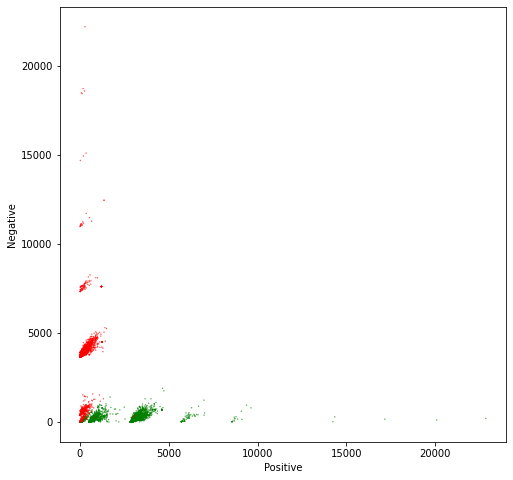

In [35]:
X = df[['bias', 'positive', 'negative']].values # Get only the numerical values of the dataframe
Y = df['sentiment'].values; # Put in Y the corresponding labels or sentiments

# Plot the samples using columns 1 and 2 of the matrix
fig, ax = plt.subplots(figsize = (8, 8))

colors = ['red', 'green']

# Color based on the sentiment Y
ax.scatter(X[:,1], X[:,2], c=[colors[int(k)] for k in Y], s = 0.1)  # Plot a dot for each pair of words
plt.xlabel("Positive")
plt.ylabel("Negative")

# Logistic regression 


### Sigmoid
* The sigmoid function is defined as: 

$$ h(z) = \frac{1}{1+\exp^{-z}} \tag{1}$$

It maps the input 'z' to a value that ranges between 0 and 1, and so it can be treated as a probability. 

In [43]:
def sigmoid(z): 
    '''
    Input:
        z: is the input (can be a scalar or an array)
    Output:
        h: the sigmoid of z
    '''
    h = 1/(1+np.exp(-z))
    return h
    
    return np.array(h)

In [38]:
# Testing sigmoid function 
if (sigmoid(0) == 0.5):
    print('SUCCESS!')
else:
    print('Oops!')

if (sigmoid(4.92) == 0.9927537604041685):
    print('CORRECT!')
else:
    print('Oops again!')

SUCCESS!
CORRECT!


### Logistic regression: regression and a sigmoid

Logistic regression takes a regular linear regression, and applies a sigmoid to the output of the linear regression.

Regression:
$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N$$
Note that the $\theta$ values are "weights".

Logistic regression
$$ h(z) = \frac{1}{1+\exp^{-z}}$$
$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N$$
'z' as the 'logits'.

### Cost function and Gradient

The cost function used for logistic regression is the average of the log loss across all training examples:

$$J(\theta) = -\frac{1}{m} \sum_{i=1}^m y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)}))\tag{5} $$
* $m$ is the number of training examples
* $y^{(i)}$ is the actual label of the i-th training example.
* $h(z(\theta)^{(i)})$ is the model's prediction for the i-th training example.

The loss function for a single training example is
$$ Loss = -1 \times \left( y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)})) \right)$$


In [39]:
# verify that when the model predicts close to 1, but the actual label is 0, the loss is a large positive value
-1 * (1 - 0) * np.log(1 - 0.9999) # loss is about 9.2

9.210340371976294

In [40]:
# verify that when the model predicts close to 0 but the actual label is 1, the loss is a large positive value
-1 * np.log(0.0001) # loss is about 9.2

9.210340371976182

#### Update the weights

Applying gradient descent to iteratively improve model's predictions by updating weight vector $\theta$,   
The gradient of the cost function $J$ with respect to one of the weights $\theta_j$ is:

$$\nabla_{\theta_j}J(\theta) = \frac{1}{m} \sum_{i=1}^m(h^{(i)}-y^{(i)})x_j \tag{5}$$
* 'i' is the index across all 'm' training examples.
* 'j' is the index of the weight $\theta_j$, so $x_j$ is the feature associated with weight $\theta_j$

* To update the weight $\theta_j$, we adjust it by subtracting a fraction of the gradient determined by $\alpha$:
$$\theta_j = \theta_j - \alpha \times \nabla_{\theta_j}J(\theta) $$
* The learning rate $\alpha$ is a value that we choose to control how big a single update will be.


## Implementing gradient descent function
* The number of iterations `num_iters` is the number of times that you'll use the entire training set.
* For each iteration, you'll calculate the cost function using all training examples (there are `m` training examples), and for all features.
* Instead of updating a single weight $\theta_i$ at a time, we can update all the weights in the column vector.
* $\mathbf{\theta}$ has dimensions (n+1, 1), where 'n' is the number of features, and there is one more element for the bias term $\theta_0$ (note that the corresponding feature value $\mathbf{x_0}$ is 1).
* The 'logits', 'z', are calculated by multiplying the feature matrix 'x' with the weight vector 'theta'.  $z = \mathbf{x}\mathbf{\theta}$
    * $\mathbf{x}$ has dimensions (m, n+1) 
    * $\mathbf{\theta}$: has dimensions (n+1, 1)
    * $\mathbf{z}$: has dimensions (m, 1)
* The prediction 'h', is calculated by applying the sigmoid to each element in 'z': $h(z) = sigmoid(z)$, and has dimensions (m,1).
* The cost function $J$ is calculated by taking the dot product of the vectors 'y' and 'log(h)'.  Since both 'y' and 'h' are column vectors (m,1), transpose the vector to the left, so that matrix multiplication of a row vector with column vector performs the dot product.
$$J = \frac{-1}{m} \times \left(\mathbf{y}^T \cdot log(\mathbf{h}) + \mathbf{(1-y)}^T \cdot log(\mathbf{1-h}) \right)$$
* The update of theta is also vectorized.  Because the dimensions of $\mathbf{x}$ are (m, n+1), and both $\mathbf{h}$ and $\mathbf{y}$ are (m, 1), we need to transpose the $\mathbf{x}$ and place it on the left in order to perform matrix multiplication, which then yields the (n+1, 1) answer we need:
$$\mathbf{\theta} = \mathbf{\theta} - \frac{\alpha}{m} \times \left( \mathbf{x}^T \cdot \left( \mathbf{h-y} \right) \right)$$

In [41]:

def gradientDescent(x, y, theta, alpha, num_iters):
    '''
    Input:
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Output:
        J: the final cost
        theta: your final weight vector
    Hint: you might want to print the cost to make sure that it is going down.
    '''
    
    m = len(x) 
    for i in range(0,num_iters):
        z = x.dot(theta)
        h = sigmoid(z)
        J = (-1)/m * (y.transpose().dot(np.log(h))+(1-y).transpose().dot(np.log(1-h)))
        theta -= alpha/m*(x.transpose().dot(h-y))
        
    J = float(J)
    return J, theta

In [42]:
np.random.seed(1)
# X input is 10 x 3 with ones for the bias terms
tmp_X = np.append(np.ones((10, 1)), np.random.rand(10, 2) * 2000, axis=1)
# Y Labels are 10 x 1
tmp_Y = (np.random.rand(10, 1) > 0.35).astype(float)

# Apply gradient descent
tmp_J, tmp_theta = gradientDescent(tmp_X, tmp_Y, np.zeros((3, 1)), 1e-8, 700)
print(f"The cost after training is {tmp_J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(tmp_theta)]}")

The cost after training is 0.67094970.
The resulting vector of weights is [4.1e-07, 0.00035658, 7.309e-05]


## Training Model

In [139]:
# collect the features 'x' and stack them into a matrix 'X'
X = df[["bias", "positive", "negative"]].values
# training labels corresponding to X
Y = train_y

# Apply gradient descent
J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-9, 1500)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

The cost after training is 0.24216529.
The resulting vector of weights is [7e-08, 0.0005239, -0.00055517]


## Visualizing the Trained Model

In [142]:
def neg(theta, pos):
    return (-theta[0] - pos * theta[1]) / theta[2]

def direction(theta, pos):
    return    pos * theta[2] / theta[1]

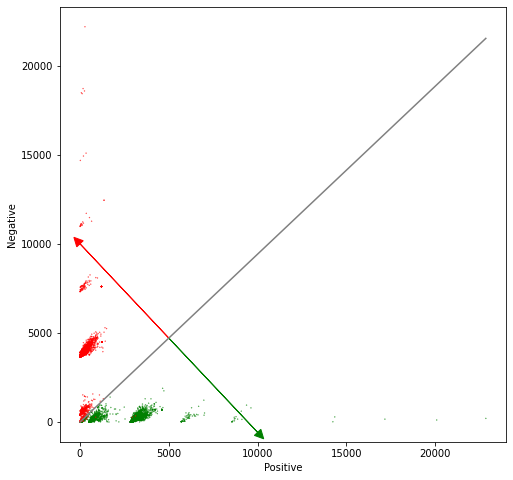

In [143]:
# Plot the samples using columns 1 and 2 of the matrix
fig, ax = plt.subplots(figsize = (8, 8))

colors = ['red', 'green']

# Color base on the sentiment Y
ax.scatter(X[:,1], X[:,2], c=[colors[int(k)] for k in Y], s = 0.1)  # Plot a dot for each pair of words
plt.xlabel("Positive")
plt.ylabel("Negative")

# Now lets represent the logistic regression model in this chart. 
maxpos = np.max(X[:,1])

offset = 5000 # The pos value for the direction vectors origin

# Plot a gray line that divides the 2 areas.
theta = np.squeeze(theta)
ax.plot([0,  maxpos], [neg(theta, 0),   neg(theta, maxpos)], color = 'gray') 

# Plot a green line pointing to the positive direction
ax.arrow(x=offset, y=neg(theta, offset), dx=offset, dy=direction(theta, offset), head_width=500, head_length=500, fc='g', ec='g')
# Plot a red line pointing to the negative direction
ax.arrow(offset, neg(theta, offset), -offset, -direction(theta, offset), head_width=500, head_length=500, fc='r', ec='r')

plt.show()

# Testing logistic regression

$$y_{pred} = sigmoid(\mathbf{x} \cdot \theta)$$

In [150]:
def predict_tweet(tweet, freqs, theta):
    '''
    Input: 
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output: 
        y_pred: the probability of a tweet being positive or negative
    '''
    x_dict = extract_features(tweet,freqs)
    x = np.zeros((1, 3))
    for i, key in enumerate(x_dict):
        x[0, i] = x_dict[key]
    y_pred = sigmoid(x.dot(theta))

    return y_pred

In [151]:
for tweet in ['I am happy', 'I am bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great']:
    print( '%s -> %f' % (tweet, predict_tweet(tweet, freqs, theta)))

I am happy -> 0.518580
I am bad -> 0.494339
this movie should have been great. -> 0.515331
great -> 0.515464
great great -> 0.530898
great great great -> 0.546273
great great great great -> 0.561561


In [152]:
# Feel free to check the sentiment of your own tweet below
my_tweet = 'I am learning :)'
predict_tweet(my_tweet, freqs, theta)

array([0.81636424])

## Checking performance using the test set
After training the model using the training set above, checking how this model might perform on real, unseen data, by testing it against the test set.

In [153]:
def test_logistic_regression(test_x, test_y, freqs, theta):
    """
    Input: 
        test_x: a list of tweets
        test_y: (m, 1) vector with the corresponding labels for the list of tweets
        freqs: a dictionary with the frequency of each pair (or tuple)
        theta: weight vector of dimension (3, 1)
    Output: 
        accuracy: (# of tweets classified correctly) / (total # of tweets)
    """
    y_hat=[]
    for tweet in test_x:
        y_pred = predict_tweet(tweet, freqs, theta)
        if y_pred>0.5:
            y_hat.append(1)
        else:
            y_hat.append(0)
    accuracy = sum(sum(np.array(y_hat) == np.array(test_y.transpose())))/len(y_hat)
    return accuracy

In [154]:
tmp_accuracy = test_logistic_regression(test_x, test_y, freqs, theta)
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")

Logistic regression model's accuracy = 0.9950


# Error Analysis

In [155]:
# Some error analysis
print('Label Predicted Tweet')
for x,y in zip(test_x,test_y):
    y_hat = predict_tweet(x, freqs, theta)

    if np.abs(y - (y_hat > 0.5)) > 0:
        print('THE TWEET IS:', x)
        print('THE PROCESSED TWEET IS:', process_tweet(x))
        print('%d\t%0.8f\t%s' % (y, y_hat, ' '.join(process_tweet(x)).encode('ascii', 'ignore')), end='\n\n')

Label Predicted Tweet
THE TWEET IS: @jaredNOTsubway @iluvmariah @Bravotv Then that truly is a LATERAL move! Now, we all know the Queen Bee is UPWARD BOUND : ) #MovingOnUp
THE PROCESSED TWEET IS: ['truli', 'later', 'move', 'know', 'queen', 'bee', 'upward', 'bound', 'movingonup']
1	0.49996890	b'truli later move know queen bee upward bound movingonup'

THE TWEET IS: @MarkBreech Not sure it would be good thing 4 my bottom daring 2 say 2 Miss B but Im gonna be so stubborn on mouth soaping ! #NotHavingit :p
THE PROCESSED TWEET IS: ['sure', 'would', 'good', 'thing', '4', 'bottom', 'dare', '2', 'say', '2', 'miss', 'b', 'im', 'gonna', 'stubborn', 'mouth', 'soap', 'nothavingit', ':p']
1	0.48622857	b'sure would good thing 4 bottom dare 2 say 2 miss b im gonna stubborn mouth soap nothavingit :p'

THE TWEET IS: I'm playing Brain Dots : ) #BrainDots
http://t.co/UGQzOx0huu
THE PROCESSED TWEET IS: ["i'm", 'play', 'brain', 'dot', 'braindot']
1	0.48370665	b"i'm play brain dot braindot"

THE TWEET IS: I'

# Predicting with our own tweet

In [156]:
my_tweet= 'This is a ridiculously bright movie. The plot was terrible and I was sad until the ending!'
print(process_tweet(my_tweet))
y_hat = predict_tweet(my_tweet, freqs, theta)
print(y_hat)
if y_hat > 0.5:
    print('Positive sentiment')
else: 
    print('Negative sentiment')

['ridicul', 'bright', 'movi', 'plot', 'terribl', 'sad', 'end']
[0.48139087]
Negative sentiment
